In this file I will work (not sure what I will do yet) with the measurements of the 16 popular traits for the 3 most popular species in iNaturalist. 

To better understand how the traits and the species were chosen, refer to the file __traits_exploring.ipynb__

For the documentation, refer to the file __TRY_6.0_Data_Release_Notes.pdf__

Funny thing! In the file __filtered_MIS_traits.txt__ the name of the file is truncated to a certain number of characters. Therefore, the name of the trait 

"Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): undefined if petiole is in- or excluded" 

appears as 

"Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA): undefined if petiole is in- or exclu"

and initially wasn't found in the trait list when looking at "top3_species_top_traits.txt" with the names. I then switched to TraitID for this reason.

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
with open('trait_id_list.txt', 'r') as openfile:
    trait_ids = openfile.read().splitlines()

print(f"There are {len(trait_ids)} traits in total\n")

#mapping them to int because they were read as strings
trait_ids = list(map(lambda x : int(x), trait_ids))


There are 16 traits in total



In [4]:
#specifing encoding='latin' is necessary or you get an error
top3_species_top_traits = pd.read_csv('top3_species_top_traits.txt', sep='\t', encoding='latin')

print("Total:", len(top3_species_top_traits))

#clear outliers: refer to the documentation obtained with the data request to better understand
#only keeping the measurement that have a value included in a range of 4 standard deviations. The rest are likely outliers or wrong.
#also keep the rows with no value in ErrorRisk, because that is metadata

#500 measurements dropped.
top3_species_top_traits = top3_species_top_traits[(top3_species_top_traits['ErrorRisk'] < 4.0) | (top3_species_top_traits['ErrorRisk'].isnull())]

print("After removing outliers:", len(top3_species_top_traits))

#now remove the duplicates. Again, refer to the documentation for more information
#4032 observations removed
top3_species_top_traits = top3_species_top_traits[top3_species_top_traits['OrigObsDataID'].isnull()]

#Note that duplicates are only referred to trait measurements.
#Therefore removing rows marked as "duplicates" might leave in the dataframe rows related to the single observation (eg. location)
#For these values, TraitName is not present. The information is located in the "DataName" column.
#If exploration is necessary, refer to the "ObservationID" of the original dataframe

print("After removing duplicates:", len(top3_species_top_traits))

#Related to what I mentioned above, now I only keep data related to the trait measurements. No metadata.
trait_measurements = top3_species_top_traits[top3_species_top_traits['TraitID'].isin(trait_ids)]

#I remove this trait because I only want numerical traits, for now.
#I can always use it again if I need to do something with it.
#For example, should I perform different analysis according to the plant growth form? (there are 121 distinct forms...)
trait_measurements_no_plant_form = trait_measurements[trait_measurements['TraitName'] != 'Plant growth form']

#I could do the same for Seedbank type if needed.



Total: 116532
After removing outliers: 116032
After removing duplicates: 112000


C:\Users\guido\AppData\Local\Temp\ipykernel_1936\400165302.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  top3_species_top_traits = pd.read_csv('top3_species_top_traits.txt', sep='\t', encoding='latin')


In [5]:
dactylis_glomerata_df = trait_measurements[trait_measurements['AccSpeciesName']=='Dactylis glomerata']
achillea_millefolium_df = trait_measurements[trait_measurements['AccSpeciesName']=='Achillea millefolium']
trifolium_pratense_df = trait_measurements[trait_measurements['AccSpeciesName']=='Trifolium pratense']

#important: remember to select AccSpeciesName and not SpeciesName, because only the first referes to the consolidated name of the
#species and you risk losing data if you don't do so (eg Achillea lanulosa)


In [6]:
columns_of_interest = ['ObservationID', 'TraitID', 'TraitName', 'OrigValueStr', 'OrigUnitStr', 'StdValue', 'UnitName']

dac_glo_trait_df = dactylis_glomerata_df[columns_of_interest]
ach_mil_trait_df = achillea_millefolium_df[columns_of_interest]
tri_pra_trait_df = trifolium_pratense_df[columns_of_interest]

dac_glo_trait_df[:5]

#I keep the observationID in case I need to link it to its metadata
#I also have to keep both Original Value and Standardized Value, because for textual data (e.g. Plant Growth Form)
#there is no standardized value

,ObservationID,TraitID,TraitName,OrigValueStr,OrigUnitStr,StdValue,UnitName
9,19150,13.0,Leaf carbon (C) content per leaf dry mass,45.85,%,458.50000,mg/g
15,19194,13.0,Leaf carbon (C) content per leaf dry mass,41.62,%,416.20000,mg/g
20,19216,14.0,Leaf nitrogen (N) content per leaf dry mass,2.78,%,27.80000,mg/g
28,19514,42.0,Plant growth form,Herbaceous Monocot,NaN,NaN,NaN
29,19514,14.0,Leaf nitrogen (N) content per leaf dry mass,1.591335,%,15.91335,mg/g


In [7]:
#just wanted to check that they are all there
# unique = list(dac_glo_trait_df['TraitName'].unique())
# print(sorted(unique))


In [8]:
#Maybe I can calculate confidence interval?

def trait_analysis(df, id):
    """
    Perform measurements on the specified TraitID (id) present in the specified dataframe (df).

    Outputs a series with the id, name, mean, std, median and unit of measure.
    """

    trait_specific_df = df[df['TraitID']==id]

    trait_values = {
        'TraitID' : id,
        'TraitName': trait_specific_df['TraitName'].iloc[0] #they are all the same
    }

    trait_values['Mean'] = trait_specific_df['StdValue'].mean()
    trait_values['Std'] = trait_specific_df['StdValue'].std()
    trait_values['Median'] = trait_specific_df['StdValue'].median()
    trait_values['UnitName'] = trait_specific_df['UnitName'].iloc[0]

    return pd.Series(trait_values)

In [9]:
dac_glo_trait_analysis = pd.DataFrame(columns=['TraitID', 'TraitName', 'Mean', 'Std', 'Median', 'UnitName'])
ach_mil_trait_analysis = pd.DataFrame(columns=['TraitID', 'TraitName', 'Mean', 'Std', 'Median', 'UnitName'])
tri_pra_trait_analysis = pd.DataFrame(columns=['TraitID', 'TraitName', 'Mean', 'Std', 'Median', 'UnitName'])

#all minus plant growth form and seedbank type for the reasons specified above (they don't have numerical values)
trait_ids_minus_plant_growth_form = [tid for tid in trait_ids if (tid != 42 and tid != 159)]

#add a row (always the last row, using the length of the dataframe) with the information related to the specified trait
for id in trait_ids_minus_plant_growth_form:
    dac_glo_trait_analysis.loc[len(dac_glo_trait_analysis)] = trait_analysis(dac_glo_trait_df, id)
    ach_mil_trait_analysis.loc[len(ach_mil_trait_analysis)] = trait_analysis(ach_mil_trait_df, id)
    tri_pra_trait_analysis.loc[len(tri_pra_trait_analysis)] = trait_analysis(tri_pra_trait_df, id)

dac_glo_trait_analysis

#careful, seedbank density and seedbank longevity median is set as 0 for all three species

#Ok, it's set as 0 because a lot of measurements have value 0... Possibly they have not been measured. 

,TraitID,TraitName,Mean,Std,Median,UnitName
0,3117,Leaf area per leaf dry mass (specific leaf are...,24.992908,7.758924,23.7225,mm2 mg-1
1,13,Leaf carbon (C) content per leaf dry mass,453.11471,23.759855,449.932,mg/g
2,55,Leaf dry mass (single leaf),73.261125,63.818979,53.3,mg
3,47,Leaf dry mass per leaf fresh mass (leaf dry ma...,0.275087,0.057974,0.267,g/g
4,163,Leaf fresh mass,0.277901,0.22095,0.224,g
5,50,Leaf nitrogen (N) content per leaf area,0.967233,0.314514,0.919261,g m-2
6,14,Leaf nitrogen (N) content per leaf dry mass,24.257659,7.137246,24.222146,mg/g
7,403,Plant biomass and allometry: Shoot dry mass (p...,1.897759,4.998163,0.32635,g
8,3106,Plant height vegetative,0.472429,0.322961,0.4,m
9,33,Seed (seedbank) longevity,0.167742,0.491532,0.0,dimensionless


In [15]:
#for each species, identify the different plant growth forms

dac_glo_growth_forms = dac_glo_trait_df[dac_glo_trait_df['TraitID'] == 42]
ach_mil_growth_forms = ach_mil_trait_df[ach_mil_trait_df['TraitID'] == 42]
tri_pra_growth_forms = tri_pra_trait_df[tri_pra_trait_df['TraitID'] == 42]

dac_glo_growth_forms[:5]

,ObservationID,TraitID,TraitName,OrigValueStr,OrigUnitStr,StdValue,UnitName
28,19514,42.0,Plant growth form,Herbaceous Monocot,NaN,NaN,NaN
37,19519,42.0,Plant growth form,Herbaceous Monocot,NaN,NaN,NaN
46,21962,42.0,Plant growth form,Herbaceous Monocot,NaN,NaN,NaN
55,23537,42.0,Plant growth form,Herbaceous Monocot,NaN,NaN,NaN
64,23662,42.0,Plant growth form,Herbaceous Monocot,NaN,NaN,NaN


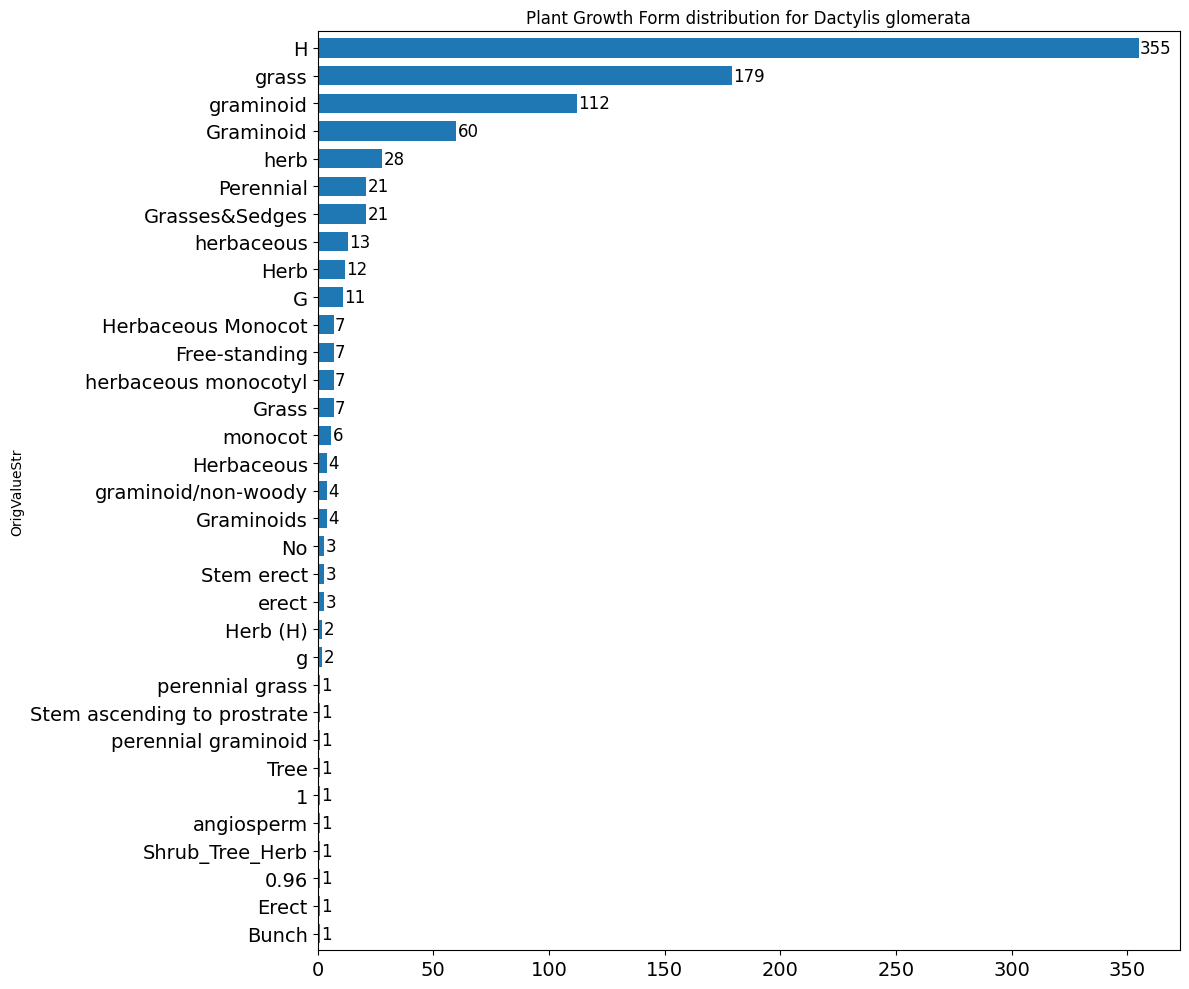

In [33]:
#find unique values of plant growth form for each species

dac_glo_growth_forms_COUNT = dac_glo_growth_forms['OrigValueStr'].value_counts()

# print(dac_glo_growth_forms_COUNT)

fig, ax = plt.subplots(figsize=(12, 10))  # Increase figure size to avoid overlap


dac_glo_growth_forms_COUNT.sort_values().plot(kind='barh', 
                                              ax=ax,
                                              width= 0.7,
                                              title='Plant Growth Form distribution for Dactylis glomerata', 
                                              fontsize=14)
#very weird values in here, like 0.96 and 1

# Add values next to bars
for i, v in enumerate(dac_glo_growth_forms_COUNT.sort_values()):
    ax.text(v + 0.5, i, str(v), color='black', va='center', fontsize=12)

# Optional: Adjust layout to fit everything
plt.tight_layout()

plt.show()
fig.savefig('./img/Dactylis_glomerata_plant_growth_forms.pdf', bbox_inches="tight")


OrigValueStr
H                     378
perennial forb        345
herb                  219
forb                   90
Forb/herb              69
herbaceous             34
no                     26
Herb                   13
Free-standing          12
herbaceous dicotyl      7
angHerb                 6
No                      4
Herbaceous              4
herb/non-woody          3
1                       3
Stem erect              3
b H                     2
Herbaceous dicots       2
Forb                    2
Herb (H)                2
erect                   2
yes                     2
Erect                   2
Rhizomatous             2
Tree                    2
Shrub_Herb              1
Forbs                   1
O                       1
h                       1
angiosperm              1
Shrub/Subshrub          1
0.98                    1
1.466683398             1
0.950301233             1
1.799231334             1
1.653737914             1
1.400651596             1
1.553589623             1

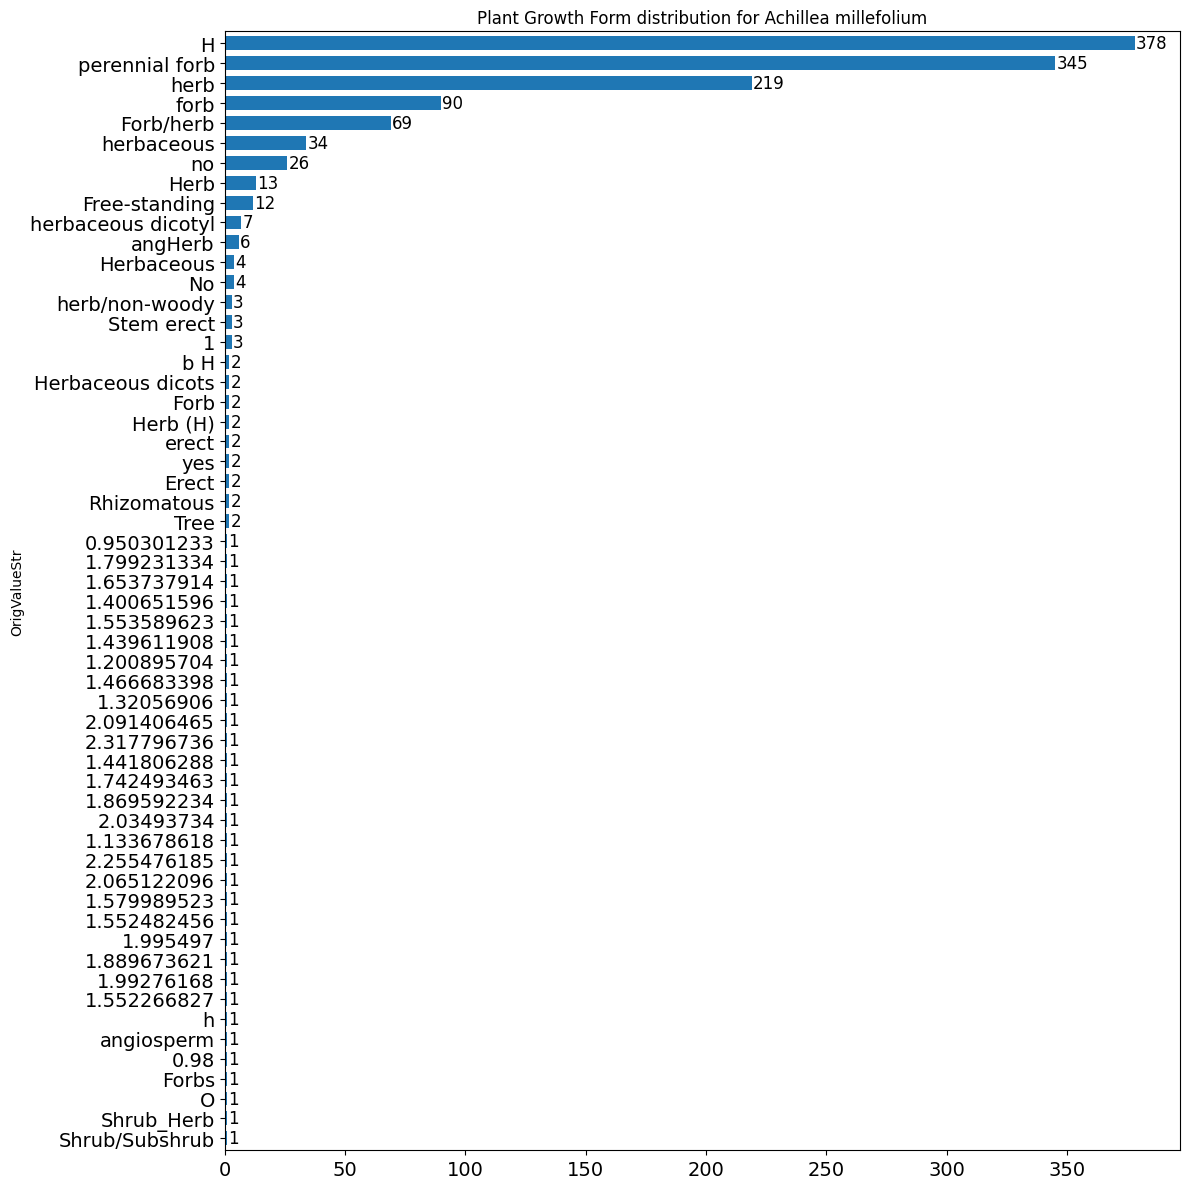

In [ ]:
ach_mil_growth_forms_COUNT = ach_mil_growth_forms['OrigValueStr'].value_counts()

print(ach_mil_growth_forms_COUNT)

fig, ax = plt.subplots(figsize=(12, 12))  # Increase figure size to avoid overlap


ach_mil_growth_forms_COUNT.sort_values().plot(kind='barh', 
                                              ax=ax,
                                              width= 0.7,
                                              title='Plant Growth Form distribution for Achillea millefolium', 
                                              fontsize=14)

# Add values next to bars
for i, v in enumerate(ach_mil_growth_forms_COUNT.sort_values()):
    ax.text(v + 0.5, i, str(v), color='black', va='center', fontsize=12)

# Optional: Adjust layout to fit everything
plt.tight_layout()

plt.show()
fig.savefig('./img/Achillea_millefolium_plant_growth_forms.pdf', bbox_inches="tight")

#Some of the numerical PGFs (Plant Growth Form) come from the same dataset and refer to leaf succulence. Consider removing it.
#Junker R.R., Martin H. Lechleitner, Jonas Kuppler, Lisa-Maria Ohler (in revision) INTERCONNECTEDNESS OF THE GRINNELLIAN AND ELTONIAN NICHE IN REGIONAL AND LOCAL PLANT-POLLINATOR COMMUNITIES. Front. Plant Sci.

#Others (value <1) can refer to consensus.
# Additionally, there is more than one "Plant Growth Form" entry for the same observation.
#e.g. plant growth form standardized or attributed diversity (but they are the same)
#This needs to be addressed, although this dataset is very small.
# Engemann, K., Sandel, B., Boyle, B., Enquist, B. J., Jørgensen, P. M., Kattge, J., McGill, B. J., Morueta-Holme, N., Peet, R. K., Spencer, N. J., Violle, C., Wiser, S. K. and Svenning, J.-C. (2016), A plant growth form dataset for the New World. Ecology, 97: 3243. doi:10.1002/ecy.1569


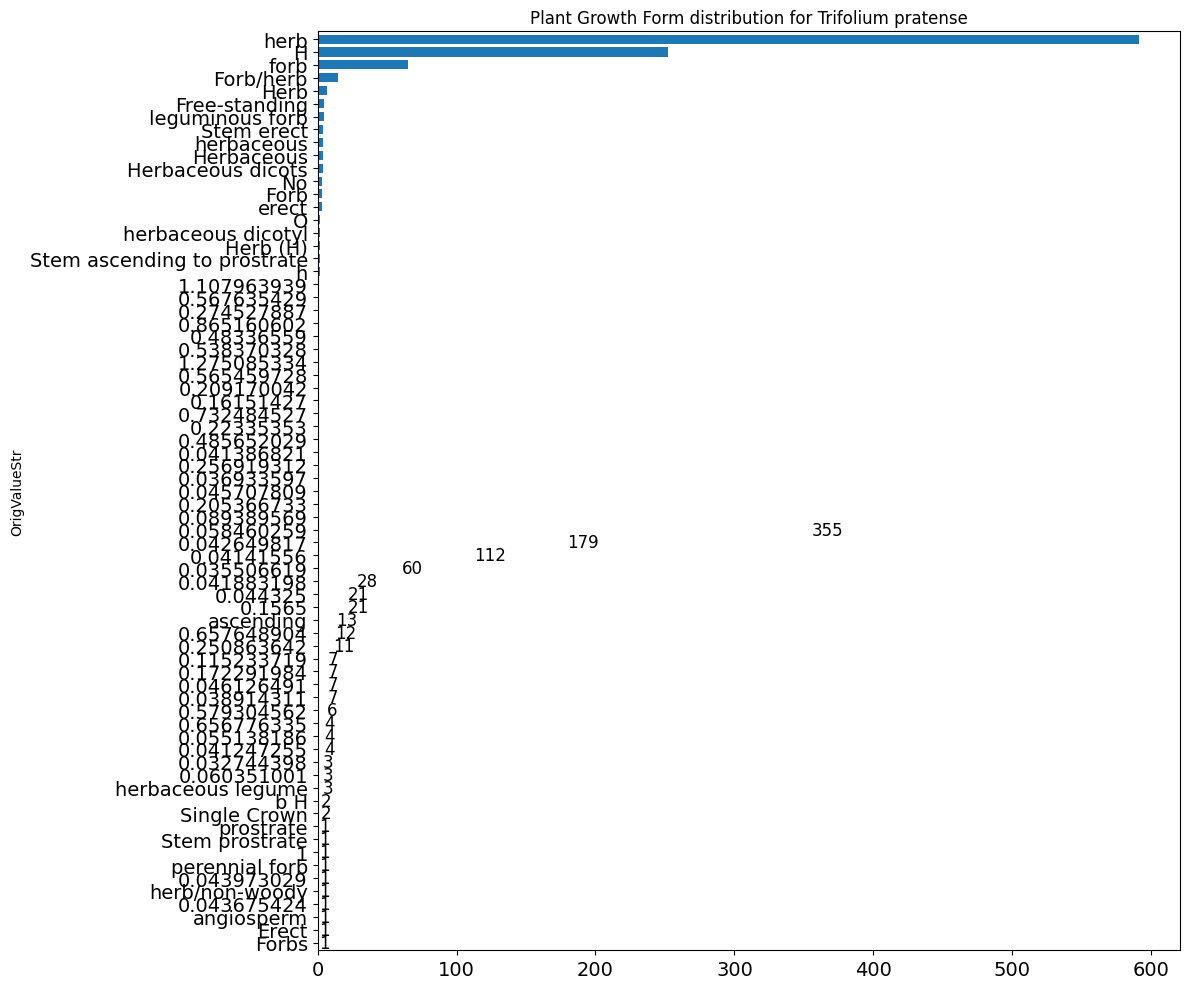

In [38]:
#find unique values of plant growth form for each species

tri_pra_growth_forms_COUNT = tri_pra_growth_forms['OrigValueStr'].value_counts()

# print(tri_pra_growth_forms_COUNT)

fig, ax = plt.subplots(figsize=(12, 10))  # Increase figure size to avoid overlap


tri_pra_growth_forms_COUNT.sort_values().plot(kind='barh', 
                                              ax=ax,
                                              width= 0.7,
                                              title='Plant Growth Form distribution for Trifolium pratense', 
                                              fontsize=14)

# Add values next to bars
for i, v in enumerate(dac_glo_growth_forms_COUNT.sort_values()):
    ax.text(v + 0.5, i, str(v), color='black', va='center', fontsize=12)

# Optional: Adjust layout to fit everything
plt.tight_layout()

plt.show()
fig.savefig('./img/Trifolium_pratense_plant_growth_forms.pdf', bbox_inches="tight")